# Методы одномерного поиска

In [43]:
import numpy as np
import matplotlib.pyplot as plt

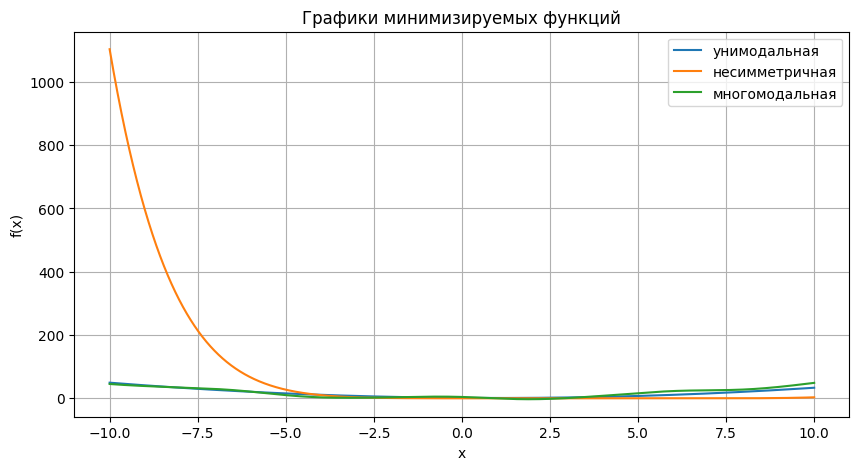

In [44]:
def f_unimod(x):
    return 0.4 * (x-1)**2 + 1
def f_nonsym(x):
    #return 0.4 * x**2 + 2*np.sin(x) + 0.2*np.cos(2 * x + 2)
    return 1e-6 * (x-3.5)**8
def f_mulmod(x):
    return 0.5 * x**2 + 5*np.sin(x-4) + 0.5*np.cos(2 * x)
    #return 0.5 * x**2 + 5*np.sin(x-4) + 5*np.cos(2 * x) + 10*np.cos(3 * x)

x_min = -10.0
x_max = 10.0
N = 10000
x = np.linspace(x_min, x_max, N)

G_plot = np.empty((3,), dtype='object')

G_plot[0] = f_unimod(x)
G_plot[1] = f_nonsym(x)
G_plot[2] = f_mulmod(x)

labels = ['унимодальная', 'несимметричная', 'многомодальная']
plt.figure(figsize=(10,5))
for lbl, G in zip(labels, G_plot):
    plt.plot(x, G, label=lbl)
plt.legend()
plt.title('Графики минимизируемых функций')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.savefig('functions.png', bbox_inches='tight')
plt.show()

In [45]:
eps = 1e-6
max_iter = 200

## Метод дихотомии

In [46]:
def dihotom_optim(f, x_min, x_max, max_iter, eps):
    x_l = x_min
    x_r = x_max
    for idx in range(max_iter):
        x_center = (x_l + x_r)/2
        x_center_l = x_center - eps/2
        x_center_r = x_center + eps/2
        if f(x_center_l) > f(x_center_r):
            x_l = x_center_r
        else:
            x_r = x_center_r
        if (x_r - x_l) < eps:
            return (x_r + x_l)/2, idx
    print('Solution had not been found (')
    
x_optim, index = dihotom_optim(f=f_nonsym, x_min=x_min, x_max=x_max, max_iter=max_iter, eps=eps)
print('x*:', x_optim)
print('Steps:', index)

x*: 3.500000564409108
Steps: 23


## Метод золотого сечения

In [47]:
def golden_ratio_optim(f, x_min, x_max, max_iter, eps):
    # Constant.
    phi = (1 + np.sqrt(5)) / 2
    # Initial step.
    x_l = x_min
    x_r = x_max
    delta = (x_r - x_l)/phi
    x_center_l = x_r - delta
    x_center_r = x_l + delta
    f_l = f(x_center_l)
    f_r = f(x_center_r)
    for idx in range(max_iter):
        if f_l > f_r:
            f_l = f_r
            x_l = x_center_l
            delta = (x_r - x_l)/phi
            x_center_l = x_center_r
            x_center_r = x_l + delta
            f_r = f(x_center_r)
        else:
            f_r = f_l
            x_r = x_center_r
            delta = (x_r - x_l)/phi
            x_center_r = x_center_l
            x_center_l = x_r - delta
            f_l = f(x_center_l)
        
        if (x_center_r - x_center_l) < eps:
            return ((x_center_r + x_center_l))/2, idx
    print('Solution had not been found (')
x_optim, index = golden_ratio_optim(f=f_nonsym, x_min=x_min, x_max=x_max, max_iter=max_iter, eps=eps)
print('x*:', x_optim)
print('Steps:', index)

x*: 3.4999999779523208
Steps: 31


## Метод парабол

Необходимо определить значения коэффициентов $a$, $b$, $c$ системы уравнений

$\left\{
\begin{aligned}
\bold{a} x_1^2 + \bold{b} x_1 + \bold{c} &= f(x_1), \\
\bold{a} x_2^2 + \bold{b} x_2 + \bold{c} &= f(x_2), \\
\bold{a} x_3^2 + \bold{b} x_3 + \bold{c} &= f(x_3)
\end{aligned}
\right.$

С этой целью обозначим

$F = \begin{bmatrix}
f(x_1) \\
f(x_2) \\
f(x_3)
\end{bmatrix}$,

$P = \begin{bmatrix}
a \\
b \\
c
\end{bmatrix}$,

$M_{sys} = \begin{bmatrix}
x_1^2 & x_1 & 1 \\
x_2^2 & x_2 & 1 \\
x_3^2 & x_3 & 1
\end{bmatrix}$.

Тогда, исходная система уравнений принимает вид

${M_{sys} \cdot P = F}$,
и ее решение:
${P = M_{sys}^{-1} F}$.

In [48]:
def parabol_optim(f, x_min, x_max, max_iter, eps):
    
    x_arr = np.array([x_min + eps, (x_max + x_min)/2, x_max - eps])
    F = np.matrix(f(x_arr)).T
    
    M_sys = np.matrix(np.ones((len(x_arr),len(x_arr))))
    for idx, x in enumerate(x_arr):
        M_sys[idx,0] = x**2
        M_sys[idx,1] = x
    
    for idx in range(max_iter):
        # Sort function values (ascending).
        index_rise = F.A[:,0].argsort()
        
        [a, b, _] = np.linalg.inv(M_sys)*F

        if np.abs(a[0,0] > 0):
            v = -b[0,0]/(2*a[0,0])
            f_v = f(v)
        else:
            # Return x-value [column=1], corresponding to the lowest function value [row=0].
            return M_sys[index_rise][0,1], idx
        
        F_rise = F[index_rise]
        #if f_v < F_rise[-1]:
        F = F_rise.copy()
        F[-1] = f_v.copy()
        M_sys = M_sys[index_rise].copy()
        M_sys[-1,0] = v**2
        M_sys[-1,1] = v.copy()
        #else:
        #    return v, idx
        
        x_sorted = M_sys[M_sys.A[:,1].argsort()][:,1]
        
        if (x_sorted[2]-x_sorted[0]) < eps:
            return (x_sorted[1])[0,0], idx+1
    print('Solution had not been found (')
x_optim, index = parabol_optim(f=f_nonsym, x_min=x_min, x_max=x_max, max_iter=max_iter, eps=eps)
print('x*:', x_optim)
print('Steps:', index)


x*: 3.5000001957749656
Steps: 23


## Комбинированный метод Брента

In [49]:
def combin_optim(f, x_min, x_max, max_iter, eps):
    # Constant.
    phi = (1 + np.sqrt(5)) / 2
    # Flag means the previous step was computed by the Golden Section.
    golden_sect_flag = False

    x_arr = np.array([x_min + eps, (x_max + x_min)/2, x_max - eps])
    F = np.matrix(f(x_arr)).T
    
    M_sys = np.matrix(np.ones((len(x_arr),len(x_arr))))
    for idx, x in enumerate(x_arr):
        M_sys[idx,0] = x**2
        M_sys[idx,1] = x
    
    x_star = x_arr[1]
    x_star_prev = x_arr[1]

    for idx in range(max_iter):
        # Sort function values (ascending).
        index_rise = F.A[:,0].argsort()
        
        [a, b, _] = np.linalg.inv(M_sys)*F

        if np.abs(a[0,0] > 0):
            v = -b[0,0]/(2*a[0,0])
            f_v = f(v)
        else:
            # Return x-value [column=1], corresponding to the lowest function value [row=0].
            return M_sys[index_rise][0,1], idx
        
        F_rise = F[index_rise]
        if f_v < F_rise[-1]:
            F = F_rise.copy()
            F[-1] = f_v.copy()
            M_sys = M_sys[index_rise].copy()
            M_sys[-1,0] = v**2
            M_sys[-1,1] = v.copy()
            if np.abs(v - x_star) > np.abs(x_star - x_star_prev)/2:
                x_star_prev = x_star.copy()
                x_star = v.copy()
                golden_sect_flag = False
            else:
                print('golden2')
                if not golden_sect_flag:
                    # Sort x-values (ascending).
                    [x_l, _, x_r] = M_sys[M_sys[:,1].A[:,0].argsort()][:,1]
                    x_l = x_l[0,0]
                    x_r = x_r[0,0]
                    
                    delta = (x_r - x_l)/phi
                    x_center_l = x_r - delta
                    x_center_r = x_l + delta
                    f_l = f(x_center_l)
                    f_r = f(x_center_r)
                    
                    golden_sect_flag = True
                if f_l > f_r:
                    M_sys[0,0] = x_center_l**2
                    M_sys[0,1] = x_center_l
                    F[0] = f_l
                    M_sys[1,0] = x_center_r**2
                    M_sys[1,1] = x_center_r
                    F[1] = f_r
                    
                    f_l = f_r
                    x_l = x_center_l
                    delta = (x_r - x_l)/phi
                    x_center_l = x_center_r
                    x_center_r = x_l + delta
                    f_r = f(x_center_r)
                    
                    M_sys[2,0] = x_center_r**2
                    M_sys[2,1] = x_center_r
                    F[2] = f_r
                else:
                    M_sys[2,0] = x_center_r**2
                    M_sys[2,1] = x_center_r
                    F[2] = f_r
                    M_sys[1,0] = x_center_l**2
                    M_sys[1,1] = x_center_l
                    F[1] = f_l
                    
                    f_r = f_l
                    x_r = x_center_r
                    delta = (x_r - x_l)/phi
                    x_center_r = x_center_l
                    x_center_l = x_r - delta
                    f_l = f(x_center_l)
                    
                    M_sys[0,0] = x_center_l**2
                    M_sys[0,1] = x_center_l
                    F[0] = f_l
                
                x_star_prev = x_star.copy()
                x_star = M_sys[1,1] 
        else:
            print('golden1')
            if not golden_sect_flag:
                # Sort x-values (ascending).
                [x_l, _, x_r] = M_sys[M_sys[:,1].A[:,0].argsort()][:,1]
                x_l = x_l[0,0]
                x_r = x_r[0,0]
                
                delta = (x_r - x_l)/phi
                x_center_l = x_r - delta
                x_center_r = x_l + delta
                f_l = f(x_center_l)
                f_r = f(x_center_r)
                
                golden_sect_flag = True
            if f_l > f_r:
                M_sys[0,0] = x_center_l**2
                M_sys[0,1] = x_center_l
                F[0] = f_l
                M_sys[1,0] = x_center_r**2
                M_sys[1,1] = x_center_r
                F[1] = f_r
                
                f_l = f_r
                x_l = x_center_l
                delta = (x_r - x_l)/phi
                x_center_l = x_center_r
                x_center_r = x_l + delta
                f_r = f(x_center_r)
                
                M_sys[2,0] = x_center_r**2
                M_sys[2,1] = x_center_r
                F[2] = f_r
            else:
                M_sys[2,0] = x_center_r**2
                M_sys[2,1] = x_center_r
                F[2] = f_r
                M_sys[1,0] = x_center_l**2
                M_sys[1,1] = x_center_l
                F[1] = f_l
                
                f_r = f_l
                x_r = x_center_r
                delta = (x_r - x_l)/phi
                x_center_r = x_center_l
                x_center_l = x_r - delta
                f_l = f(x_center_l)
                
                M_sys[0,0] = x_center_l**2
                M_sys[0,1] = x_center_l
                F[0] = f_l
            
            x_star_prev = x_star.copy()
            x_star = M_sys[1,1]
        x_sorted = M_sys[M_sys.A[:,1].argsort()][:,1]
        
        if (x_sorted[2]-x_sorted[0]) < eps:
            return (x_sorted[1])[0,0], idx+1
    print('Solution had not been found (')
x_optim, index = combin_optim(f=f_nonsym, x_min=x_min, x_max=x_max, max_iter=max_iter, eps=eps)
print('x*:', x_optim)
print('Steps:', index)


golden2
golden2
golden2
golden2
golden2
x*: 3.500006416009321
Steps: 118
